In [1]:
import os
from tramdag import TramDagModel, TramDagConfig

In [2]:
cfg=TramDagConfig()
cfg.setup_configuration(EXPERIMENT_DIR='counterf') # works also without arguments, then default paths are used

Configuration already exists: counterf/configuration.json


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


n = 1000

x1 = np.random.normal(loc=0, scale=1, size=n)
x2 = np.random.choice([0,1], size=n)
x3 = np.random.choice([0,1,2], size=n)
x4 = np.random.exponential(scale=1.0, size=n)
x5 = np.random.choice([0,1,2,3], size=n)
x6 = np.random.exponential(scale=1.0, size=n)
x7 = np.random.choice([0,1,2,3,4], size=n)


df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "x3": x3,
    "x4": x4,
    "x5": x5,
    "x6": x6,
    "x7": x7,
})

print(df.head())


# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

         x1  x2  x3        x4  x5        x6  x7
0  2.299390   1   2  1.631302   3  1.097431   3
1  0.379243   1   0  0.389709   3  0.417097   1
2 -2.338256   0   2  0.607827   3  1.262630   2
3  0.109419   0   2  1.472605   1  1.693149   4
4 -0.049431   0   2  1.817009   3  0.430692   1


In [4]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'x2':'ordinal_Xn_Yo', 
            'x3':'ordinal_Xn_Yo',
            'x4':'continous',
            'x5':'ordinal_Xn_Yo',
            'x6':'continous',
            'x7':'ordinal_Xn_Yo',} 

cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
x3                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
x4                   | continous       | continuous [c]                 | continuous [c]                
x5                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
x6                   | continous       | continuous [c]  

/home/bule/TramDag/tramdag/utils/configuration.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


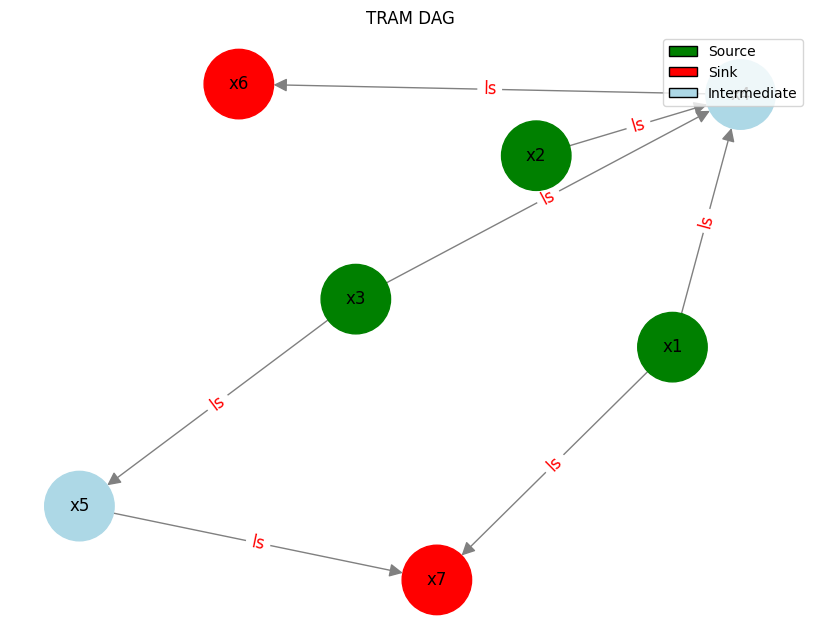

In [5]:
cfg.set_meta_adj_matrix(seed=123) #Create the (Meta) Adjacency Matrix

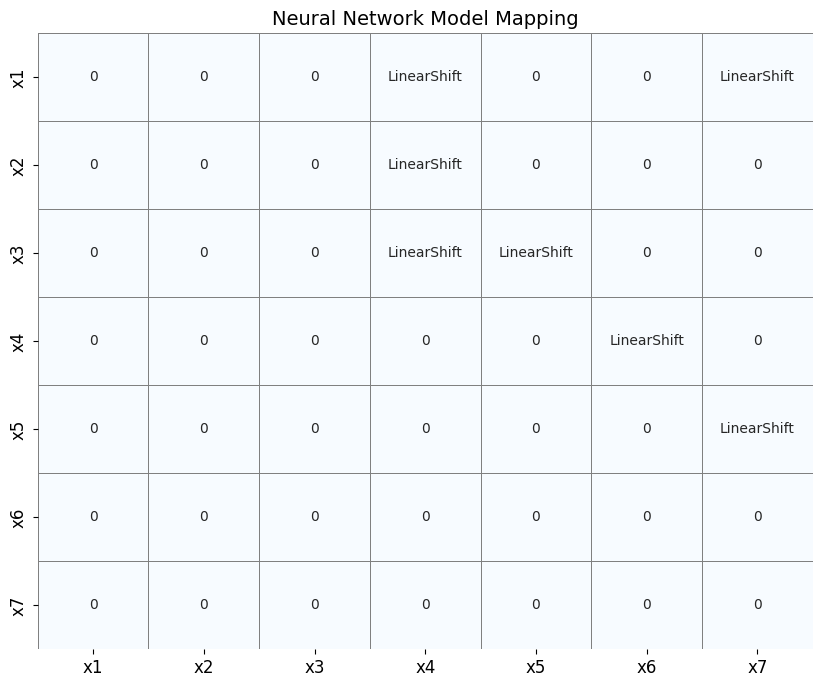

In [6]:
cfg.set_tramdag_nn_models() 


In [7]:
cfg.compute_levels(train_df)

In [8]:
from tramdag import TramDagModel
device='cpu'
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data =train_df )

In [9]:
td_model.load_or_compute_minmax(td_train_data=train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to counterf/min_max_scaling.json


In [10]:
sub = test_df.sample(n=3, random_state=42)
sub

,x1,x2,x3,x4,x5,x6,x7
365,0.027670,0,1,0.064338,2,0.430478,2
583,1.453515,1,0,0.193426,1,0.137226,1
879,1.702687,0,0,0.567449,0,0.810082,1


In [11]:
u_df = td_model.get_latent(sub)

[Warning] best_model.pt not found, falling back to initial_model.pt


[Warning] best_model.pt not found, using initial_model.pt
[WARNING] Ordinal 'x3' has 2 unique values, expected 3. Skipping strict comparison.
[Warning] best_model.pt not found, using initial_model.pt
[WARNING] Ordinal 'x3' has 2 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.int64(0), np.int64(1)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x3' has 2 unique values, expected 3. Skipping strict comparison.
[Warning] best_model.pt not found, falling back to initial_model.pt
[WARNING] Ordinal 'x3' has 2 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.int64(0), np.int64(1)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x5' has 3 unique values, expected 4. Skipping strict comparison.
[WARNING] Ordinal 'x3' has 2 unique values, expected 3. Skipping s

In [12]:
u_df

,x1,x1_U,x2,x2_U_lower,x2_U_upper,x3,x3_U_lower,x3_U_upper,x4,x4_U,x5,x5_U_lower,x5_U_upper,x6,x6_U,x7,x7_U_lower,x7_U_upper
365,0.027670,-0.067717,0,-inf,-0.052619,1,-0.065436,0.715471,0.064338,0.624425,2,0.495760,1.643078,0.430478,-0.266495,2,1.525054,2.703892
583,1.453515,0.199362,1,-0.052619,inf,0,-inf,-0.065436,0.193426,-0.319879,1,-0.177933,0.479688,0.137226,-0.215052,1,0.512001,1.176519
879,1.702687,0.229539,0,-inf,-0.052619,0,-inf,-0.065436,0.567449,-0.302283,0,-inf,-0.177933,0.810082,0.190419,1,1.135429,1.799947


In [ ]:
# TODO FIX THE CONTINOUS SAMPLING

samples, latents = td_model.sample(predefined_latent_samples_df=u_df,number_of_counterfactual_samples=100)

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 3
[INFO] Deleting all previously sampled data.
Deleted directory: counterf/x1/sampling
Deleted directory: counterf/x2/sampling
Deleted directory: counterf/x3/sampling
Deleted directory: counterf/x4/sampling
Deleted directory: counterf/x5/sampling
Deleted directory: counterf/x6/sampling
Deleted directory: counterf/x7/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x1'. Using initial weights instead.
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1186.33it/s]


[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x2'. Using initial weights instead.
[INFO] Detected 'x2_U_lower' and 'x2_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x2: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x3'. Using initial weights instead.
[INFO] Detected 'x3_U_lower' and 'x3_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x3: 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


[INFO] Completed sampling for node 'x3'

----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x4'. Using initial weights instead.
[INFO] Using predefined latents samples for node x4 from dataframe column: x4_U


Sampling x4:   0%|          | 0/3 [00:00<?, ?it/s]

[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.float64(0.0)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(1.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x4:  33%|███▎      | 1/3 [00:00<00:01,  1.97it/s]

[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.float64(1.0)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(0.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x4:  67%|██████▋   | 2/3 [00:01<00:00,  1.95it/s]

[WARNING] Ordinal 'x2' has 1 unique values in data but is configured for 2 levels — using configured value.
[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x2' has only observed levels [np.float64(0.0)] but is configured for 2 — keeping encoding dimension 2.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(0.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x2' has 1 unique values, expected 2. Skipping strict comparison.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x4: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


[INFO] Completed sampling for node 'x4'

----*----------*-------------*--------Sample Node: x5 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x5'. Using initial weights instead.
[INFO] Detected 'x5_U_lower' and 'x5_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x5:   0%|          | 0/3 [00:00<?, ?it/s]

[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(1.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x5:  33%|███▎      | 1/3 [00:00<00:00,  4.66it/s]

[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(0.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x5:  67%|██████▋   | 2/3 [00:00<00:00,  4.06it/s]

[WARNING] Ordinal 'x3' has 1 unique values in data but is configured for 3 levels — using configured value.
[WARNING] Ordinal predictor 'x3' has only observed levels [np.float64(0.0)] but is configured for 3 — keeping encoding dimension 3.
[WARNING] Ordinal 'x3' has 1 unique values, expected 3. Skipping strict comparison.


Sampling x5: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


[INFO] Completed sampling for node 'x5'

----*----------*-------------*--------Sample Node: x6 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x6'. Using initial weights instead.
[INFO] Using predefined latents samples for node x6 from dataframe column: x6_U


Sampling x6: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


[INFO] Completed sampling for node 'x6'

----*----------*-------------*--------Sample Node: x7 ------------*-----------------*-------------------*--
[WARNING] Best model not found for node 'x7'. Using initial weights instead.
[INFO] Detected 'x7_U_lower' and 'x7_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x7:   0%|          | 0/3 [00:00<?, ?it/s]

[WARNING] Ordinal 'x5' has 1 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.float64(2.0)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x5' has 1 unique values, expected 4. Skipping strict comparison.


Sampling x7:  33%|███▎      | 1/3 [00:00<00:00,  4.20it/s]

[WARNING] Ordinal 'x5' has 1 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.float64(1.0)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x5' has 1 unique values, expected 4. Skipping strict comparison.


Sampling x7:  67%|██████▋   | 2/3 [00:00<00:00,  1.92it/s]

[WARNING] Ordinal 'x5' has 1 unique values in data but is configured for 4 levels — using configured value.
[WARNING] Ordinal predictor 'x5' has only observed levels [np.float64(0.0)] but is configured for 4 — keeping encoding dimension 4.
[WARNING] Ordinal 'x5' has 1 unique values, expected 4. Skipping strict comparison.


Sampling x7: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

[INFO] Completed sampling for node 'x7'
[INFO] DAG sampling completed successfully for all nodes.


In [18]:
samples['x6']['vals'][0]

tensor([-1.3958e+02, -1.1130e+02, -1.0379e+02, -9.3088e+01, -9.1815e+01,
        -9.1361e+01, -8.1958e+01, -8.0194e+01, -7.8110e+01, -7.7430e+01,
        -7.6781e+01, -7.6004e+01, -7.3542e+01, -7.3302e+01, -7.2090e+01,
        -7.1224e+01, -7.0875e+01, -7.0039e+01, -6.7537e+01, -6.6292e+01,
        -6.6147e+01, -6.5885e+01, -6.4936e+01, -6.4609e+01, -6.4609e+01,
        -6.0833e+01, -6.0625e+01, -6.0558e+01, -6.0243e+01, -5.9359e+01,
        -5.7158e+01, -5.6678e+01, -5.6669e+01, -5.6579e+01, -5.5523e+01,
        -5.5477e+01, -5.4931e+01, -5.3971e+01, -5.3863e+01, -5.3674e+01,
        -5.3216e+01, -5.3198e+01, -5.2972e+01, -5.2600e+01, -5.2395e+01,
        -5.1833e+01, -5.1759e+01, -4.9995e+01, -4.9766e+01, -4.9761e+01,
        -4.9720e+01, -4.9403e+01, -4.9094e+01, -4.9061e+01, -4.8779e+01,
        -4.8490e+01, -4.8203e+01, -4.7760e+01, -4.7221e+01, -4.6469e+01,
        -4.6178e+01, -4.5529e+01, -4.5139e+01, -4.4857e+01, -4.4629e+01,
        -4.4344e+01, -4.4279e+01, -4.3629e+01, -4.3